In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [ ]:
def get_dataset():
    #get train data
    dataset_path ='drive/MyDrive/TIES4911/demo1/Automobile_price_data_Raw_set.csv'
    dataset = pd.read_csv(dataset_path)
    
    return dataset

def get_combined_data():
  #reading train data
  dataset = get_dataset()
  dataset.dropna(axis=0, inplace=True)

  target = dataset.price
  dataset.drop(['price'],axis = 1 , inplace = True)

  combined = dataset
  combined.reset_index(inplace=True)
  combined = dataset[['make', 'body-style', 'wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg']]
  return combined, target

In [ ]:
dataset = get_dataset()
combined, target = get_combined_data()

In [ ]:
target.head()

3     13950.0
4     17450.0
6     17710.0
8     23875.0
10    16430.0
Name: price, dtype: float64

In [ ]:
combined.head()

,make,body-style,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg
0,audi,sedan,99.8,109,102.0,5500.0,30
1,audi,sedan,99.4,136,115.0,5500.0,22
2,audi,sedan,105.8,136,110.0,5500.0,25
3,audi,sedan,105.8,131,140.0,5500.0,20
4,bmw,sedan,101.2,108,101.0,5800.0,29


In [ ]:
def get_cols_with_no_nans(df,col_type):
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [ ]:
combined.isnull().sum()

make           0
body-style     0
wheel-base     0
engine-size    0
horsepower     0
peak-rpm       0
highway-mpg    0
dtype: int64

In [ ]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [ ]:
combined.head()

,make,body-style,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg
0,audi,sedan,99.8,109,102.0,5500.0,30
1,audi,sedan,99.4,136,115.0,5500.0,22
2,audi,sedan,105.8,136,110.0,5500.0,25
3,audi,sedan,105.8,131,140.0,5500.0,20
4,bmw,sedan,101.2,108,101.0,5800.0,29


In [ ]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 5
Number of nun-numerical columns with no nan values : 2


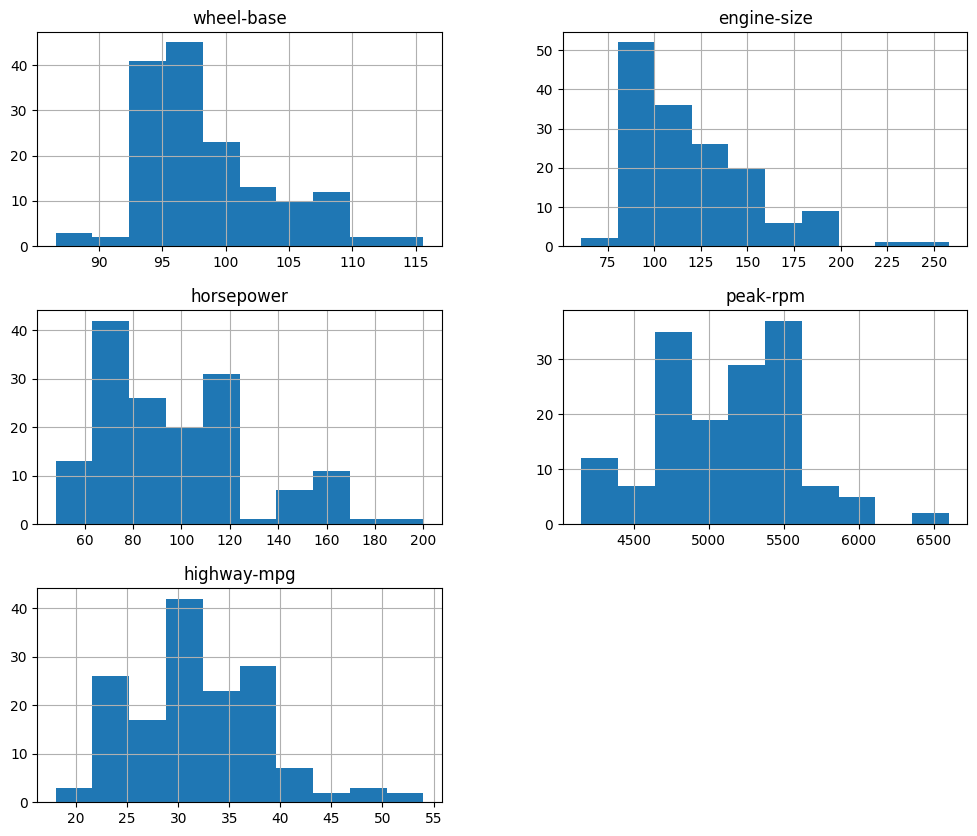

In [ ]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

<ipython-input-13-208de8e63af5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = target
<ipython-input-13-208de8e63af5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  C_mat = train_data.corr()


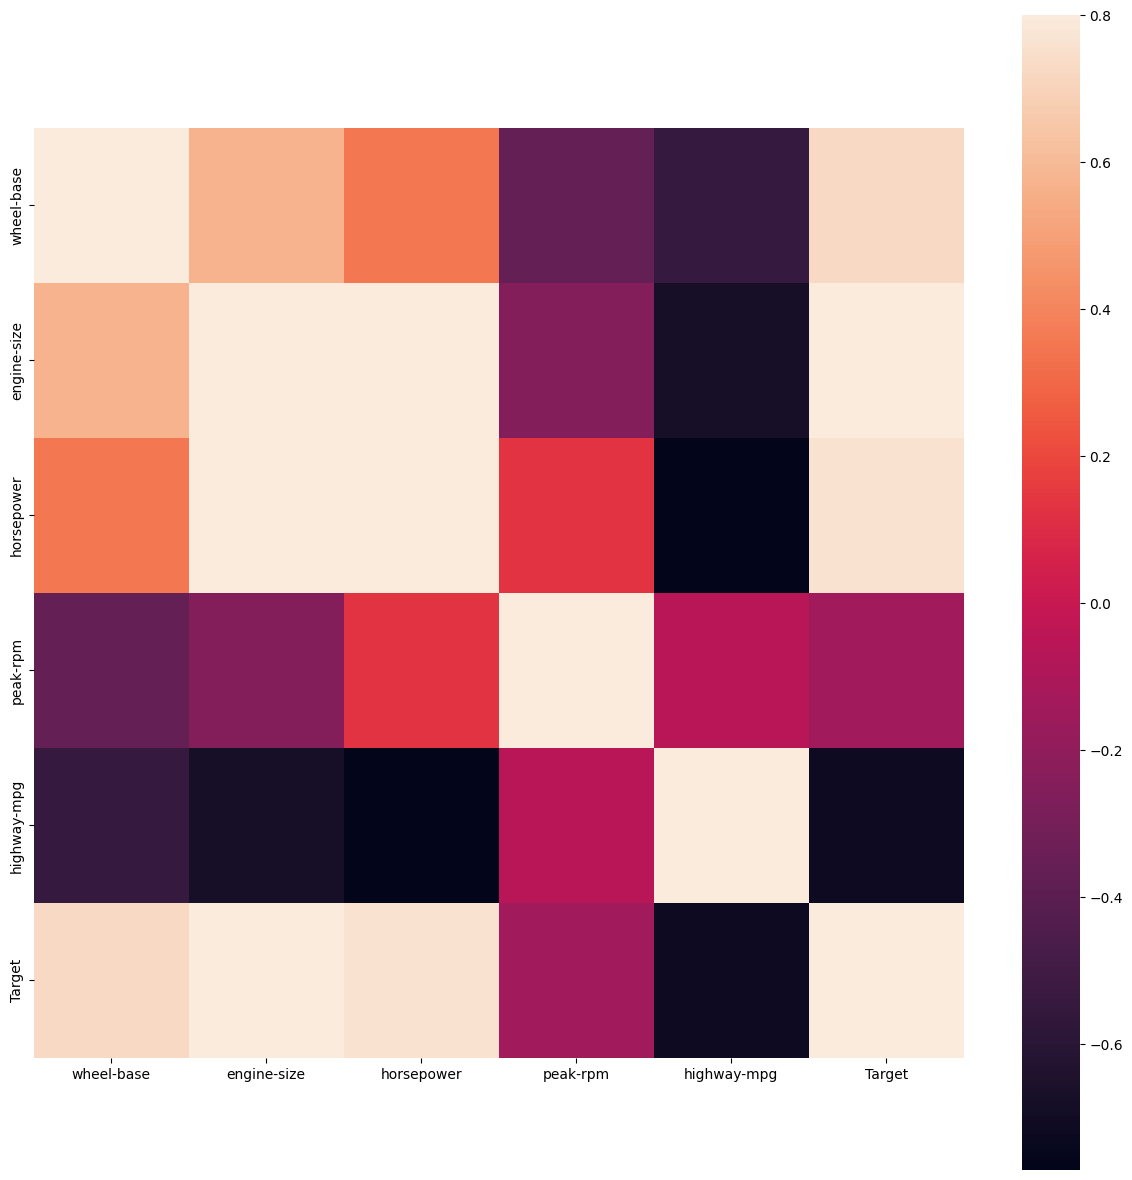

In [ ]:
train_data = dataset[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 7 columns before encoding categorical features
There are 28 columns after encoding categorical features


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(combined, target, test_size = 0.2,random_state = 0)

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = combined.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               3712      
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'drive/MyDrive/TIES4911/demo1/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
4/4 [==============================] - 1s 77ms/step - loss: 11958.9502 - mean_absolute_error: 11958.9502 - val_loss: 11006.2012 - val_mean_absolute_error: 11006.2012
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 11590.6787 - mean_absolute_error: 11590.6787 - val_loss: 10340.2441 - val_mean_absolute_error: 10340.2441
Epoch 3/500
4/4 [==============================] - 0s 21ms/step - loss: 10785.7939 - mean_absolute_error: 10785.7939 - val_loss: 8826.2236 - val_mean_absolute_error: 8826.2236
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 8983.8125 - mean_absolute_error: 8983.8125 - val_loss: 5679.5693 - val_mean_absolute_error: 5679.5693
Epoch 5/500
4/4 [==============================] - 0s 22ms/step - loss: 5697.3247 - mean_absolute_error: 5697.3247 - val_loss: 3481.1521 - val_mean_absolute_error: 3481.1521
Epoch 6/500
4/4 [==============================] - 0s 25ms/step - loss: 5514.5791 - mean_absolute_error: 5514.5791 - val

In [ ]:
mse_value, acc = NN_model.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 76ms/step - loss: 1871.1958 - mean_absolute_error: 1871.1958


In [ ]:
combined.head()

,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,...,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon
0,99.8,109,102.0,5500.0,30,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,99.4,136,115.0,5500.0,22,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,105.8,136,110.0,5500.0,25,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,105.8,131,140.0,5500.0,20,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,101.2,108,101.0,5800.0,29,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
x_test.head()

,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,...,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon
26,96.5,110,86.0,5800.0,33,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
135,97.3,109,85.0,5250.0,34,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
63,94.5,97,69.0,5200.0,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
105,95.7,92,62.0,4800.0,38,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
24,96.5,92,76.0,6000.0,34,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def get_prediction():
    #get train data
    dataset_path ='drive/MyDrive/TIES4911/demo1/prediction-data.csv'
    prediction = pd.read_csv(dataset_path)

    num_cols = get_cols_with_no_nans(prediction , 'num')
    cat_cols = get_cols_with_no_nans(prediction , 'no_num')

    prediction = oneHotEncode(prediction,cat_cols)
    
    return prediction

prediction = get_prediction()

In [ ]:
prediction.head()

,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg,make_audi,body-style_hatchback
0,99.5,131,160,5500,22,1,1


In [ ]:
prediction.reindex(columns=combined.columns, fill_value=0)

,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,...,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon
0,99.5,131,160,5500,22,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
combined.columns

Index(['wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg',
       'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda',
       'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mitsubishi',
       'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche',
       'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen',
       'make_volvo', 'body-style_convertible', 'body-style_hardtop',
       'body-style_hatchback', 'body-style_sedan', 'body-style_wagon'],
      dtype='object')

In [ ]:
x_test.head()

,wheel-base,engine-size,horsepower,peak-rpm,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,...,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon
26,96.5,110,86.0,5800.0,33,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
135,97.3,109,85.0,5250.0,34,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
63,94.5,97,69.0,5200.0,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
105,95.7,92,62.0,4800.0,38,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
24,96.5,92,76.0,6000.0,34,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
predictions = NN_model.predict(prediction.reindex(columns=combined.columns, fill_value=0))

1/1 [==============================] - 1s 545ms/step


In [ ]:
predictions

array([[17879.87]], dtype=float32)

Accuary:  0.9006092179278484


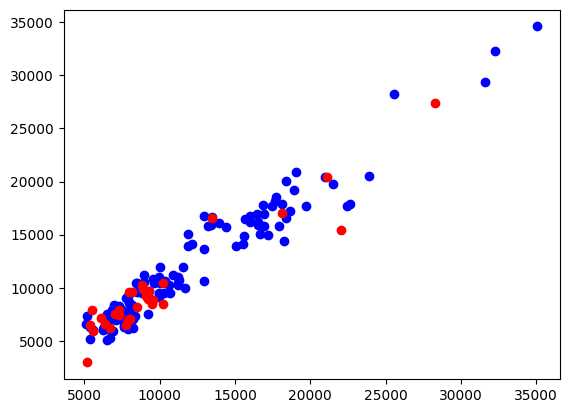

In [ ]:
from sklearn.linear_model import LinearRegression

# scikit-learn
regressor = LinearRegression()
model = regressor.fit(x_train, y_train)

print('Accuary: ', regressor.score(x_test, y_test))
plt.scatter(y_train, model.predict(x_train), color='blue')
plt.scatter(y_test, regressor.predict(x_test), color='red')

In [ ]:
regressor.predict(prediction.reindex(columns=combined.columns, fill_value=0))

array([20325.7064915])